Comparison of Optimization Algorithms for Total Variation Denoising
===================================================================

This example compares the performance of alternating direction method of
multipliers (ADMM), linearized ADMM, proximal ADMM, and primal–dual
hybrid gradient (PDHG) in solving the isotropic total variation (TV)
denoising problem

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - \mathbf{x}
  \|_2^2 + \lambda R(\mathbf{x}) \;,$$

where $R$ is the isotropic TV: the sum of the norms of the gradient
vectors at each point in the image $\mathbf{x}$.

In [1]:
import jax

from xdesign import SiemensStar, discrete_phantom

import scico.numpy as snp
import scico.random
from scico import functional, linop, loss, plot
from scico.optimize import PDHG, LinearizedADMM, ProximalADMM
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
phantom = SiemensStar(32)
N = 256  # image size
x_gt = snp.pad(discrete_phantom(phantom, N - 16), 8)
x_gt = jax.device_put(x_gt)  # convert to jax type, push to GPU

Add noise to create a noisy test image.

In [3]:
σ = 1.0  # noise standard deviation
noise, key = scico.random.randn(x_gt.shape, seed=0)
y = x_gt + σ * noise

Construct operators and functionals and set regularization parameter.

In [4]:
# The append=0 option makes the results of horizontal and vertical
# finite differences the same shape, which is required for the L21Norm.
C = linop.FiniteDifference(input_shape=x_gt.shape, append=0)
f = loss.SquaredL2Loss(y=y)
λ = 1e0
g = λ * functional.L21Norm()

The first step of the first-run solver is much slower than the
following steps, presumably due to just-in-time compilation of
relevant operators in first use. The code below performs a preliminary
solver step, the result of which is discarded, to reduce this bias in
the timing results. The precise cause of the remaining differences in
time required to compute the first step of each algorithm is unknown,
but it is worth noting that this difference becomes negligible when
just-in-time compilation is disabled (e.g. via the JAX_DISABLE_JIT
environment variable).

In [5]:
solver_admm = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[1e1],
    x0=y,
    maxiter=1,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"maxiter": 1}),
)
solver_admm.solve();  # fmt: skip
# trailing semi-colon suppresses output in notebook

Solve via ADMM with a maximum of 2 CG iterations.

In [6]:
solver_admm = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[1e1],
    x0=y,
    maxiter=200,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"maxiter": 2}),
    itstat_options={"display": True, "period": 10},
)
print(f"Solving on {device_info()}\n")
print("ADMM solver")
solver_admm.solve()
hist_admm = solver_admm.itstat_object.history(transpose=True)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)

ADMM solver
Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  1.40e-01  1.091e+05  2.558e+01  5.271e+01      0  0.000e+00


  10  2.65e-01  6.960e+04  1.884e+00  3.853e+01      2  7.618e-03
  20  3.66e-01  4.935e+04  1.897e+00  2.586e+01      2  1.172e-02


  30  4.66e-01  4.083e+04  1.496e+00  1.586e+01      2  1.610e-02
  40  5.36e-01  3.778e+04  1.051e+00  9.000e+00      2  1.810e-02
  50  6.00e-01  3.686e+04  9.501e-01  4.501e+00      2  1.591e-02


  60  6.64e-01  3.658e+04  6.075e-01  2.463e+00      2  1.198e-02
  70  7.26e-01  3.649e+04  3.780e-01  1.417e+00      2  8.286e-03
  80  7.88e-01  3.646e+04  2.292e-01  8.587e-01      2  5.376e-03


  90  8.52e-01  3.645e+04  1.398e-01  5.456e-01      2  3.453e-03
 100  9.14e-01  3.644e+04  8.440e-02  3.627e-01      2  2.166e-03
 110  9.78e-01  3.644e+04  5.169e-02  2.491e-01      2  1.372e-03


 120  1.05e+00  3.644e+04  3.236e-02  1.729e-01      2  8.665e-04
 130  1.11e+00  3.644e+04  2.151e-02  1.217e-01      2  5.562e-04
 140  1.17e+00  3.644e+04  1.534e-02  8.570e-02      2  3.660e-04
 150  1.24e+00  3.644e+04  1.153e-02  6.129e-02      2  2.421e-04


 160  1.30e+00  3.644e+04  9.567e-03  4.413e-02      2  1.645e-04
 170  1.37e+00  3.644e+04  8.241e-03  3.210e-02      2  1.147e-04
 180  1.43e+00  3.644e+04  7.308e-03  2.360e-02      2  8.159e-05


 190  1.49e+00  3.644e+04  6.741e-03  1.722e-02      1  9.906e-05
 199  1.54e+00  3.644e+04  6.107e-03  1.316e-02      1  8.171e-05


Solve via Linearized ADMM.

In [7]:
solver_ladmm = LinearizedADMM(
    f=f,
    g=g,
    C=C,
    mu=1e-2,
    nu=1e-1,
    x0=y,
    maxiter=200,
    itstat_options={"display": True, "period": 10},
)
print("\nLinearized ADMM solver")
solver_ladmm.solve()
hist_ladmm = solver_ladmm.itstat_object.history(transpose=True)


Linearized ADMM solver


Iter  Time      Objective  Prml Rsdl  Dual Rsdl
-----------------------------------------------
   0  1.69e-01  1.091e+05  2.558e+01  5.271e+01


  10  2.08e-01  8.977e+04  9.443e-01  2.388e+01
  20  2.39e-01  7.318e+04  1.084e+00  1.887e+01
  30  2.70e-01  6.165e+04  1.107e+00  1.466e+01
  40  3.00e-01  5.376e+04  1.052e+00  1.132e+01
  50  3.31e-01  4.839e+04  9.777e-01  8.744e+00
  60  3.61e-01  4.476e+04  8.857e-01  6.784e+00


  70  3.94e-01  4.229e+04  7.644e-01  5.304e+00


  80  4.27e-01  4.060e+04  6.668e-01  4.169e+00
  90  4.60e-01  3.943e+04  5.803e-01  3.299e+00
 100  4.91e-01  3.861e+04  4.986e-01  2.638e+00
 110  5.21e-01  3.804e+04  4.368e-01  2.122e+00
 120  5.54e-01  3.763e+04  3.748e-01  1.721e+00


 130  5.85e-01  3.734e+04  3.208e-01  1.407e+00


 140  6.18e-01  3.712e+04  2.743e-01  1.163e+00
 150  6.49e-01  3.696e+04  2.337e-01  9.682e-01
 160  6.90e-01  3.684e+04  2.075e-01  8.081e-01
 170  7.38e-01  3.675e+04  1.793e-01  6.827e-01


 180  7.83e-01  3.668e+04  1.580e-01  5.784e-01


 190  8.32e-01  3.663e+04  1.410e-01  4.934e-01
 199  8.72e-01  3.659e+04  1.232e-01  4.303e-01


Solve via Proximal ADMM.

In [8]:
mu, nu = ProximalADMM.estimate_parameters(C)
solver_padmm = ProximalADMM(
    f=f,
    g=g,
    A=C,
    rho=1e0,
    mu=mu,
    nu=nu,
    x0=y,
    maxiter=200,
    itstat_options={"display": True, "period": 10},
)
print("\nProximal ADMM solver")
solver_padmm.solve()
hist_padmm = solver_padmm.itstat_object.history(transpose=True)


Proximal ADMM solver
Iter  Time      Objective  Prml Rsdl  Dual Rsdl
-----------------------------------------------
   0  1.43e-01  5.520e+04  2.416e+02  3.137e+02


  10  2.11e-01  3.717e+04  1.711e+01  1.037e+01
  20  2.73e-01  3.641e+04  4.983e+00  2.067e+00
  30  3.37e-01  3.639e+04  2.059e+00  6.782e-01
  40  3.99e-01  3.640e+04  1.085e+00  2.710e-01


  50  4.70e-01  3.641e+04  7.107e-01  1.273e-01
  60  5.40e-01  3.642e+04  5.284e-01  7.349e-02
  70  6.07e-01  3.642e+04  4.251e-01  5.362e-02


  80  6.75e-01  3.642e+04  3.547e-01  3.680e-02
  90  7.44e-01  3.643e+04  3.032e-01  3.109e-02
 100  8.07e-01  3.643e+04  2.638e-01  2.467e-02


 110  8.74e-01  3.643e+04  2.327e-01  1.944e-02
 120  9.28e-01  3.643e+04  2.085e-01  1.807e-02
 130  9.71e-01  3.643e+04  1.888e-01  1.331e-02
 140  1.01e+00  3.643e+04  1.712e-01  1.355e-02


 150  1.05e+00  3.643e+04  1.569e-01  1.120e-02
 160  1.09e+00  3.643e+04  1.444e-01  9.894e-03
 170  1.13e+00  3.644e+04  1.335e-01  8.742e-03
 180  1.17e+00  3.644e+04  1.240e-01  7.370e-03
 190  1.21e+00  3.644e+04  1.156e-01  6.876e-03


 199  1.25e+00  3.644e+04  1.084e-01  6.526e-03


Solve via PDHG.

In [9]:
tau, sigma = PDHG.estimate_parameters(C, factor=1.5)
solver_pdhg = PDHG(
    f=f,
    g=g,
    C=C,
    tau=tau,
    sigma=sigma,
    maxiter=200,
    itstat_options={"display": True, "period": 10},
)
print("\nPDHG solver")
solver_pdhg.solve()
hist_pdhg = solver_pdhg.itstat_object.history(transpose=True)


PDHG solver
Iter  Time      Objective  Prml Rsdl  Dual Rsdl
-----------------------------------------------
   0  5.39e-03  5.628e+04  2.062e+02  3.060e+02


  10  4.04e-02  3.784e+04  8.370e+00  1.505e+01
  20  7.29e-02  3.688e+04  2.138e+00  5.857e+00
  30  1.08e-01  3.668e+04  8.751e-01  3.468e+00
  40  1.41e-01  3.660e+04  4.924e-01  2.411e+00
  50  1.73e-01  3.656e+04  3.199e-01  1.816e+00


  60  2.11e-01  3.654e+04  2.248e-01  1.442e+00


  70  2.45e-01  3.652e+04  1.676e-01  1.183e+00
  80  2.78e-01  3.650e+04  1.298e-01  9.970e-01
  90  3.11e-01  3.650e+04  1.032e-01  8.585e-01
 100  3.42e-01  3.649e+04  8.618e-02  7.466e-01
 110  3.73e-01  3.648e+04  7.156e-02  6.628e-01
 120  4.05e-01  3.648e+04  5.956e-02  5.933e-01


 130  4.38e-01  3.647e+04  5.127e-02  5.359e-01


 140  4.72e-01  3.647e+04  4.385e-02  4.875e-01
 150  5.04e-01  3.647e+04  3.789e-02  4.485e-01
 160  5.36e-01  3.647e+04  3.419e-02  4.127e-01
 170  5.68e-01  3.646e+04  2.966e-02  3.830e-01
 180  6.01e-01  3.646e+04  2.819e-02  3.556e-01


 190  6.34e-01  3.646e+04  2.530e-02  3.317e-01


 199  6.65e-01  3.646e+04  2.326e-02  3.123e-01


Plot results. It is worth noting that:

1. PDHG outperforms ADMM both with respect to iterations and time.
2. Proximal ADMM has similar performance to PDHG with respect to iterations,
   but is slightly inferior with respect to time.
3. ADMM greatly outperforms Linearized ADMM with respect to iterations.
4. ADMM slightly outperforms Linearized ADMM with respect to time. This is
   possible because the ADMM $\mathbf{x}$-update can be solved relatively
   cheaply, with only 2 CG iterations. If more CG iterations were required,
   the time comparison would be favorable to Linearized ADMM.

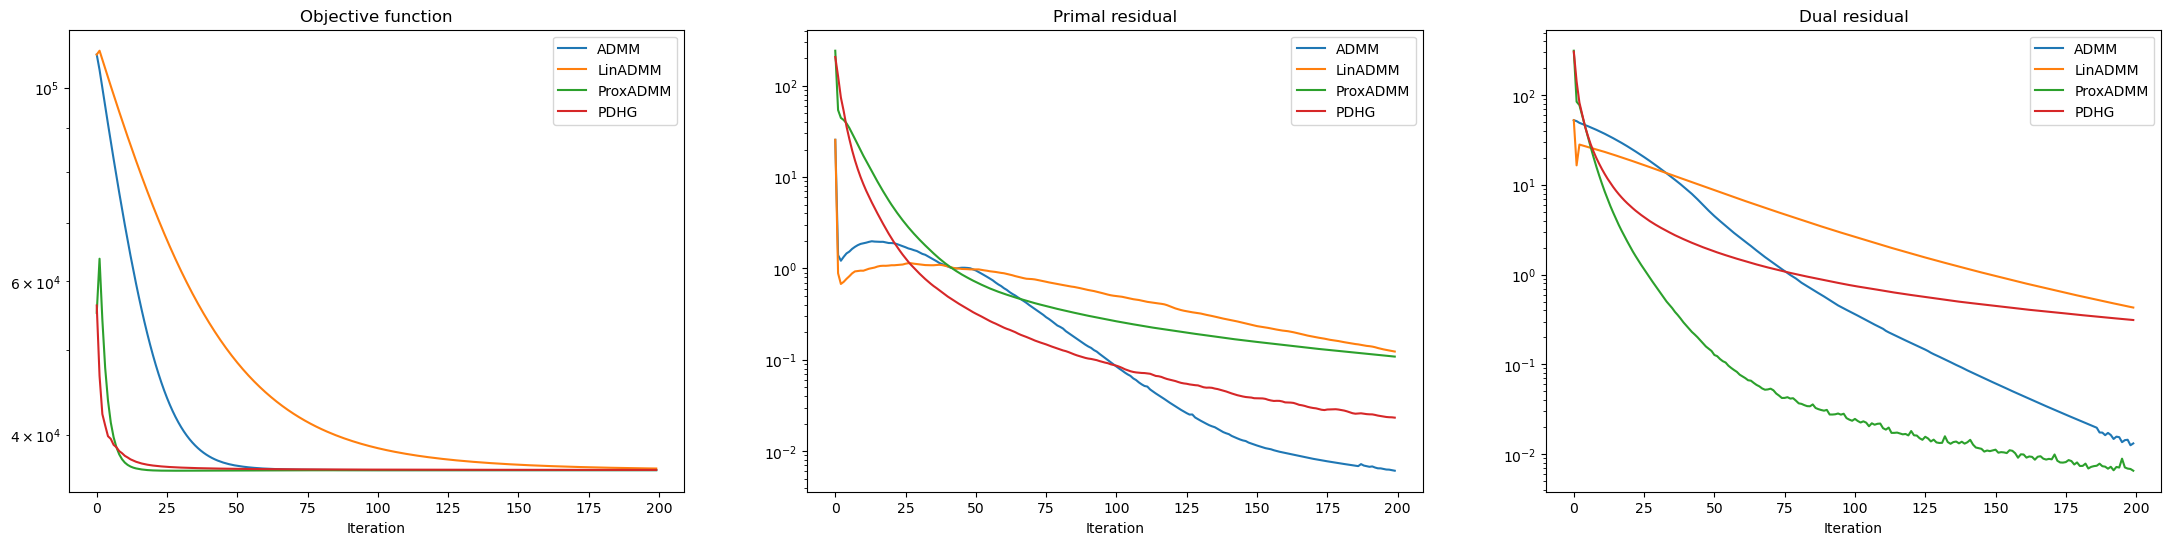

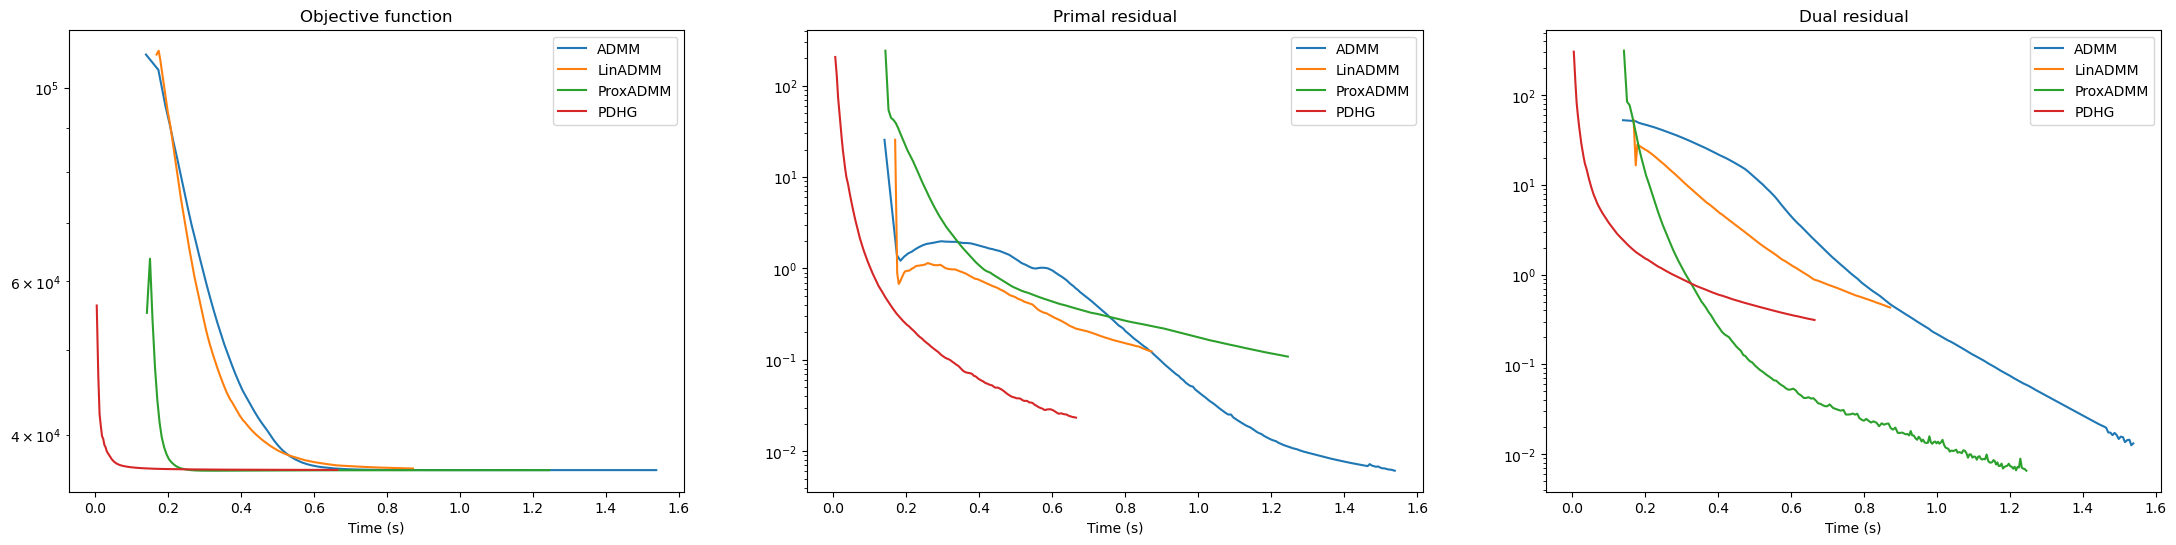

In [10]:
fig, ax = plot.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(27, 6))
plot.plot(
    snp.vstack(
        (hist_admm.Objective, hist_ladmm.Objective, hist_padmm.Objective, hist_pdhg.Objective)
    ).T,
    ptyp="semilogy",
    title="Objective function",
    xlbl="Iteration",
    lgnd=("ADMM", "LinADMM", "ProxADMM", "PDHG"),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack(
        (hist_admm.Prml_Rsdl, hist_ladmm.Prml_Rsdl, hist_padmm.Prml_Rsdl, hist_pdhg.Prml_Rsdl)
    ).T,
    ptyp="semilogy",
    title="Primal residual",
    xlbl="Iteration",
    lgnd=("ADMM", "LinADMM", "ProxADMM", "PDHG"),
    fig=fig,
    ax=ax[1],
)
plot.plot(
    snp.vstack(
        (hist_admm.Dual_Rsdl, hist_ladmm.Dual_Rsdl, hist_padmm.Dual_Rsdl, hist_pdhg.Dual_Rsdl)
    ).T,
    ptyp="semilogy",
    title="Dual residual",
    xlbl="Iteration",
    lgnd=("ADMM", "LinADMM", "ProxADMM", "PDHG"),
    fig=fig,
    ax=ax[2],
)
fig.show()

fig, ax = plot.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(27, 6))
plot.plot(
    snp.vstack(
        (hist_admm.Objective, hist_ladmm.Objective, hist_padmm.Objective, hist_pdhg.Objective)
    ).T,
    snp.vstack((hist_admm.Time, hist_ladmm.Time, hist_padmm.Time, hist_pdhg.Time)).T,
    ptyp="semilogy",
    title="Objective function",
    xlbl="Time (s)",
    lgnd=("ADMM", "LinADMM", "ProxADMM", "PDHG"),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack(
        (hist_admm.Prml_Rsdl, hist_ladmm.Prml_Rsdl, hist_padmm.Prml_Rsdl, hist_pdhg.Prml_Rsdl)
    ).T,
    snp.vstack((hist_admm.Time, hist_ladmm.Time, hist_padmm.Time, hist_pdhg.Time)).T,
    ptyp="semilogy",
    title="Primal residual",
    xlbl="Time (s)",
    lgnd=("ADMM", "LinADMM", "ProxADMM", "PDHG"),
    fig=fig,
    ax=ax[1],
)
plot.plot(
    snp.vstack(
        (hist_admm.Dual_Rsdl, hist_ladmm.Dual_Rsdl, hist_padmm.Dual_Rsdl, hist_pdhg.Dual_Rsdl)
    ).T,
    snp.vstack((hist_admm.Time, hist_ladmm.Time, hist_padmm.Time, hist_pdhg.Time)).T,
    ptyp="semilogy",
    title="Dual residual",
    xlbl="Time (s)",
    lgnd=("ADMM", "LinADMM", "ProxADMM", "PDHG"),
    fig=fig,
    ax=ax[2],
)
fig.show()